## Описание данных:

age: Возраст человека, количественный показатель

sex: Пол человека, бинарный показатель (male/female)

bmi: Индекс массы тела человека (масса тела, деленная на рост^2, измеряется в кг/м^2), количественный показатель

children: Количество детей человека (страховка покрывает детей тоже), количественный показатель

smoker: Является ли человек курильщиком, бинарный пкоазатель (yes/no)

region: Регион проживания человека, категориальный показатель (northeast, southeast, southwest, northwest)

charges: Расходы по страховке человека, количественный показатель

## Загрузка данных и библиотек:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
%pip install yellowbrick
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

Note: you may need to restart the kernel to use updated packages.


In [2]:
df_orig = pd.read_csv('insurance.csv') #Источник: https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv
df_orig.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Предобработка данных

In [3]:
#Посмотрим на тип данных по столбцам
df_orig.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
#Найдём повторы и удалим их
df_clean = df_orig
df_clean[df_clean.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [5]:
df_clean.drop_duplicates(inplace = True)

In [6]:
df_clean.isnull().sum() 
#Пропусков в данных нет

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
df_clean.describe()
#Посмотрим на количественные данные

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
df_clean.describe(exclude = 'number')
# Посмотрим на категориальные данные

,sex,smoker,region
count,1337,1337,1337
unique,2,2,4
top,male,no,southeast
freq,675,1063,364


<AxesSubplot:xlabel='bmi', ylabel='charges'>

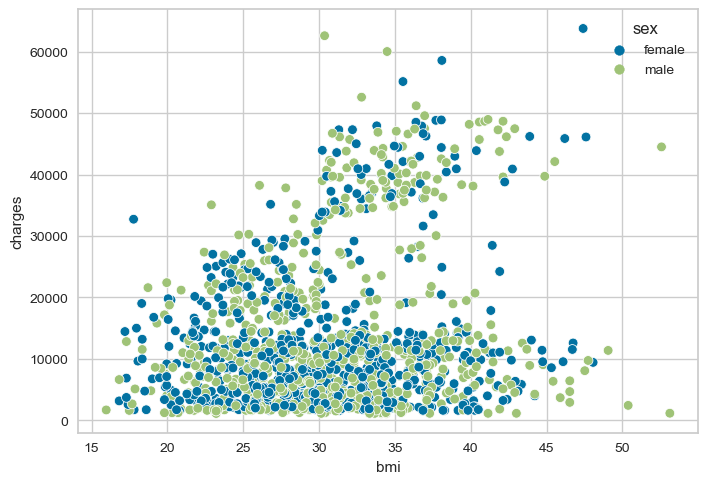

In [9]:
sns.scatterplot(data = df_clean, y = 'charges', x ='bmi', hue = 'sex')

<AxesSubplot:xlabel='sex', ylabel='charges'>

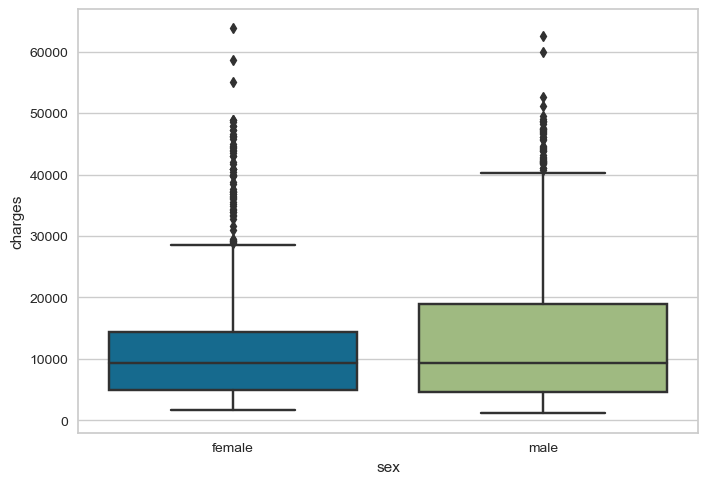

In [10]:
sns.boxplot(data=df_clean, y="charges", x="sex")

<AxesSubplot:xlabel='bmi', ylabel='charges'>

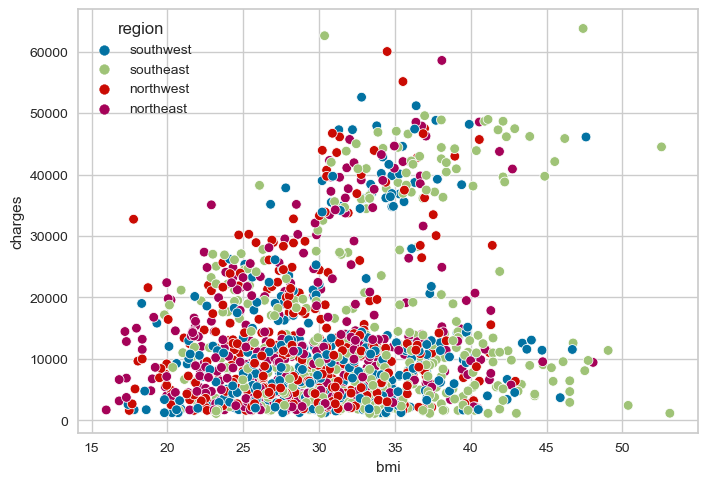

In [11]:
sns.scatterplot(data = df_clean, y = 'charges', x ='bmi', hue = 'region')

<AxesSubplot:xlabel='region', ylabel='charges'>

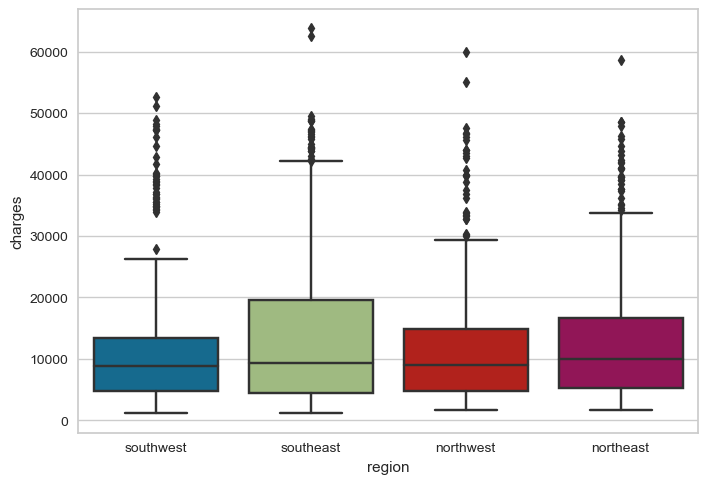

In [12]:
sns.boxplot(data=df_clean, y="charges", x="region")

<AxesSubplot:xlabel='age', ylabel='charges'>

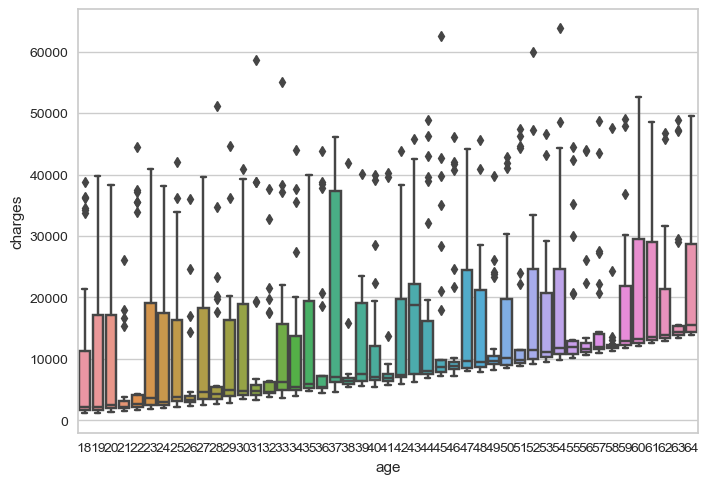

In [13]:
sns.boxplot(data=df_clean, y="charges", x="age")

<AxesSubplot:xlabel='age', ylabel='charges'>

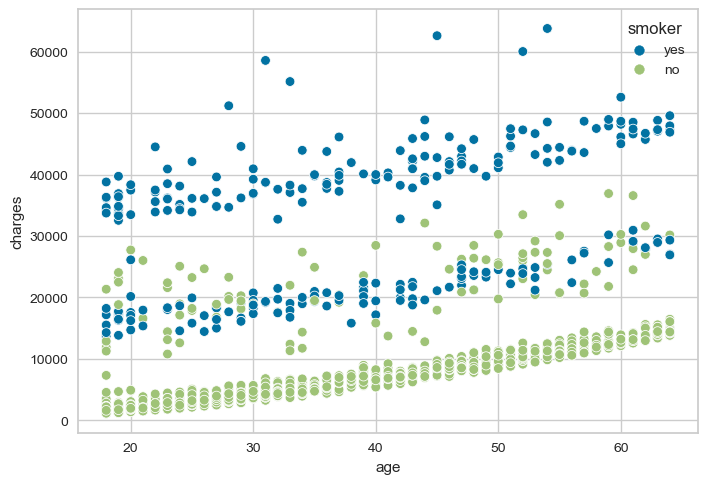

In [14]:
sns.scatterplot(data = df_clean, y = 'charges', x ='age', hue = 'smoker')

<AxesSubplot:xlabel='bmi', ylabel='charges'>

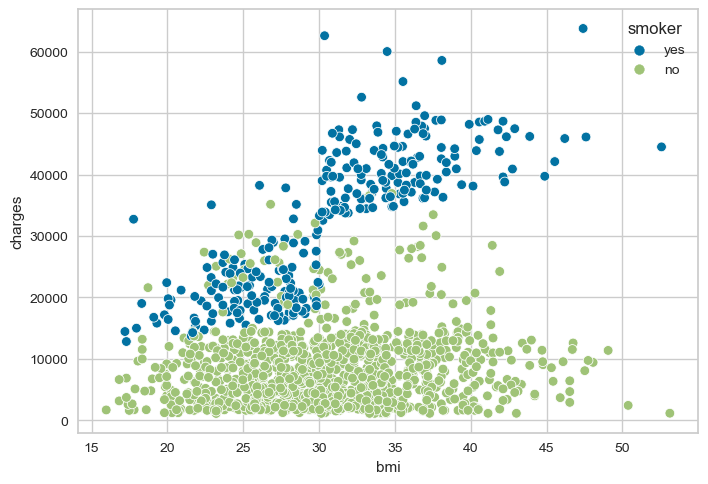

In [15]:
sns.scatterplot(data = df_clean, y = 'charges', x ='bmi', hue = 'smoker')

<AxesSubplot:xlabel='smoker', ylabel='charges'>

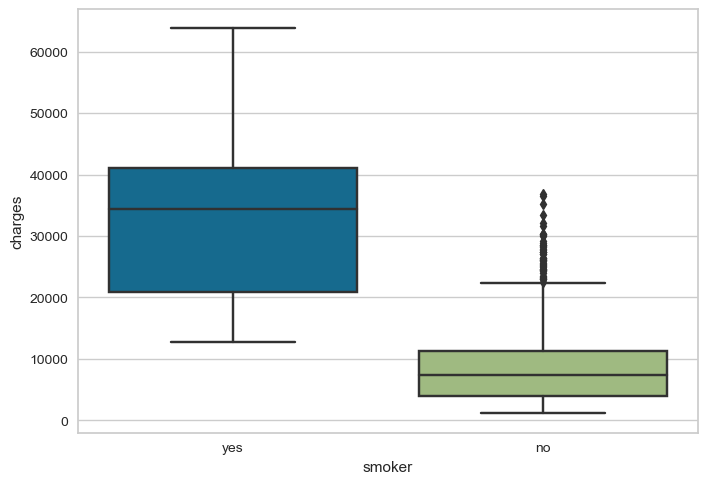

In [16]:
sns.boxplot(data=df_clean, y="charges", x="smoker")

<AxesSubplot:xlabel='children', ylabel='charges'>

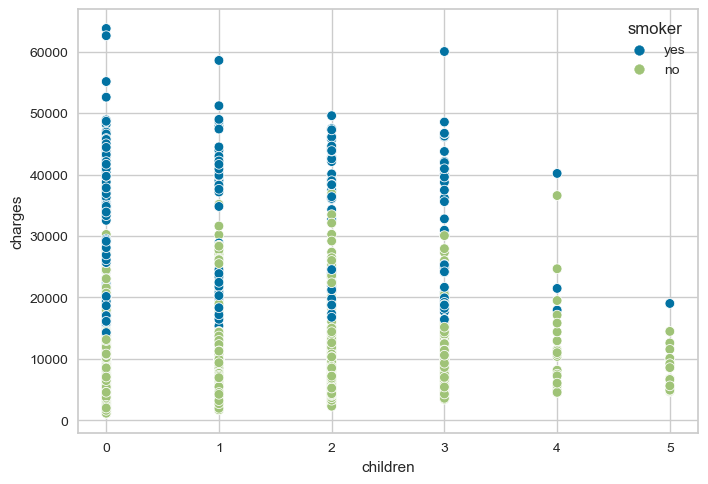

In [17]:
sns.scatterplot(data = df_clean, y = 'charges', x ='children', hue = 'smoker')

<AxesSubplot:xlabel='children', ylabel='charges'>

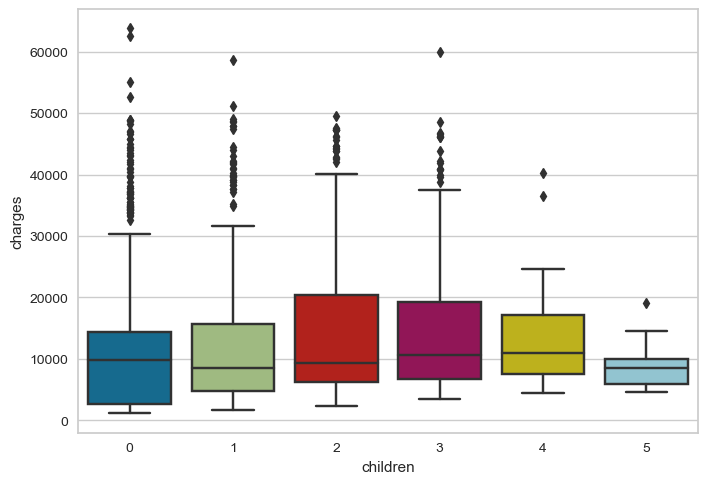

In [18]:
sns.boxplot(data=df_clean, y="charges", x="children")

In [19]:
#Проверим корреляцию
df_clean.corr()

,age,bmi,children,charges
age,1.000000,0.109344,0.041536,0.298308
bmi,0.109344,1.000000,0.012755,0.198401
children,0.041536,0.012755,1.000000,0.067389
charges,0.298308,0.198401,0.067389,1.000000


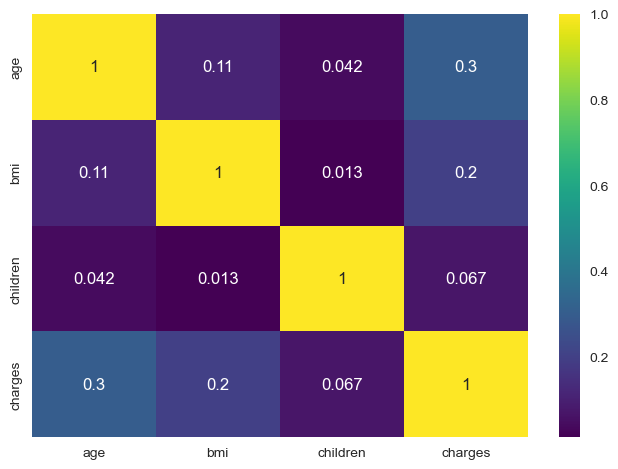

In [20]:
#Визуализируя прошлый пункт
sns.heatmap(df_clean.corr(), annot = True, cmap = 'viridis')
plt.show()

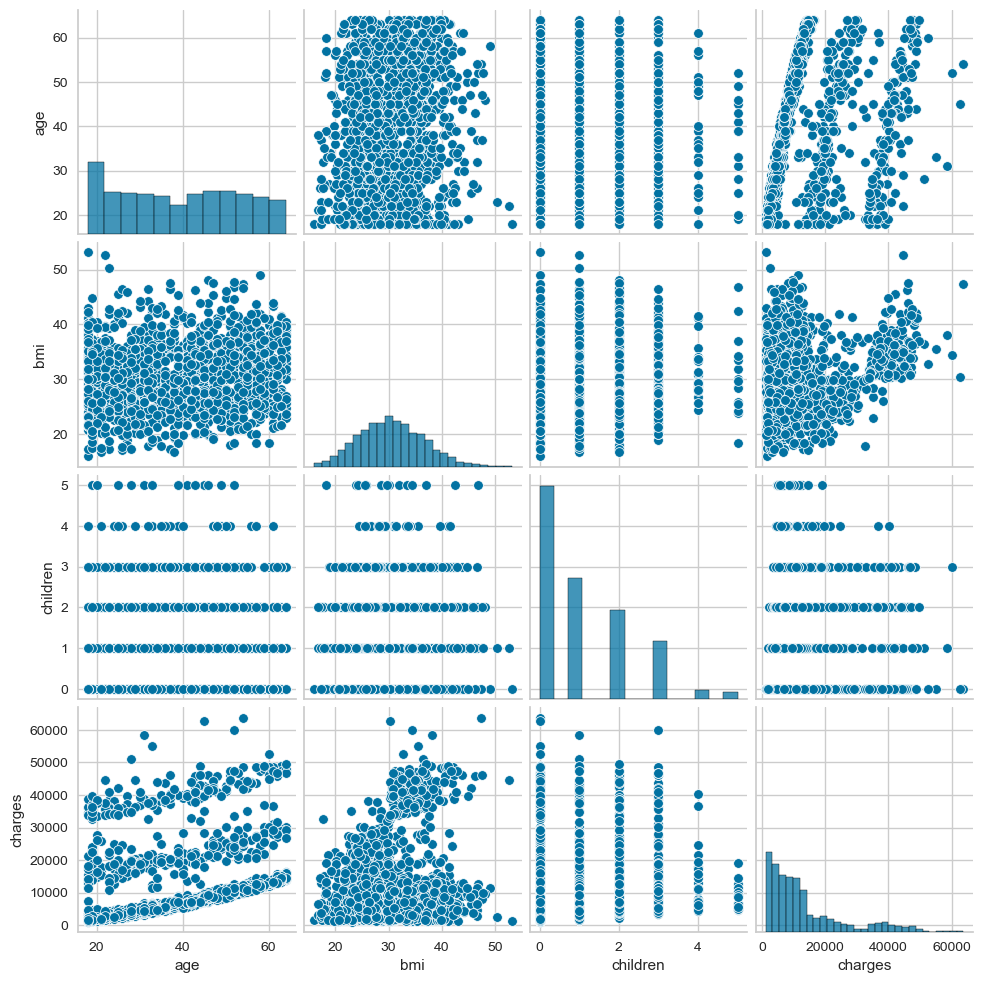

In [21]:
sns.pairplot(df_clean)
plt.show()

Сильной корреляции между регрессорами нет, распределение ИМТ похоже на нормальное, чего не сказать про возраст и кол-во детей

In [22]:
df_clean.groupby('smoker')['charges'].agg(['mean', 'count'])

,mean,count
smoker,,
no,8440.660307,1063
yes,32050.231832,274


In [23]:
#Избавимся от выбросов в данных (https://www.codecamp.ru/blog/remove-outliers-python/)
a = df_clean.shape[0]
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['age', 'bmi', 'children']])) < 3).all(axis=1)]
print(f'Было удалено {a - df_clean.shape[0]} наблюдений')  

Было удалено 22 наблюдений


<function matplotlib.pyplot.show(close=None, block=None)>

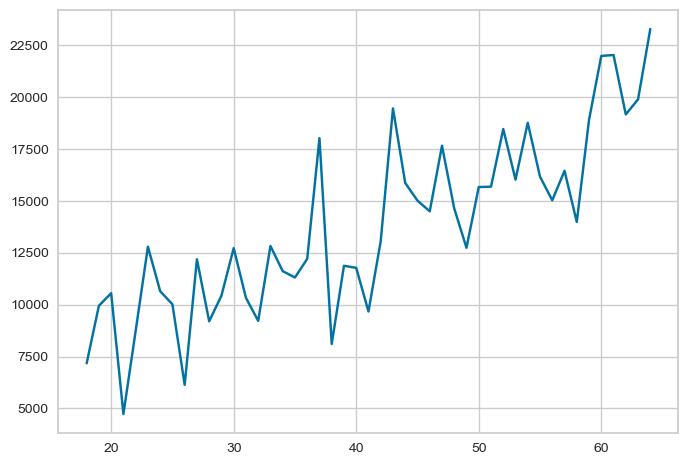

In [24]:
plt.plot(df_clean.groupby("age")["charges"].agg(["mean"]))
plt.show

In [25]:
df_clean.groupby("region")["charges"].agg(["mean"])

,mean
region,
northeast,13466.453778
northwest,12461.630457
southeast,14812.183256
southwest,12445.430216


<AxesSubplot:xlabel='region'>

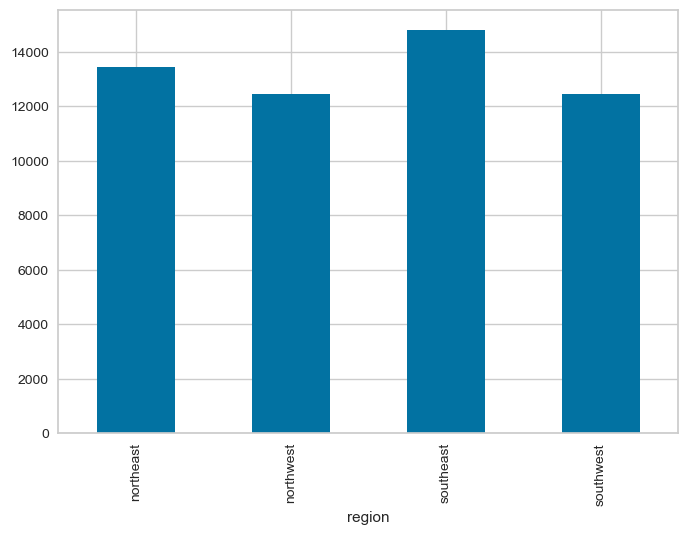

In [26]:
df_clean.groupby("region")["charges"].mean().plot(kind = 'bar')

In [27]:
#Проверим нормальность распределения тестом Шапиро-Улика (http://www.machinelearning.ru/wiki/index.php?title=Критерий_Шапиро-Уилка)
def shapiro_test(column):
    stat, p = stats.shapiro(column)
    if p < 0.05:
        return(f'Распределение не нормальное, p-value: {p}')
    else:
        return(f'распределение нормальное, p-value: {p}')

for column in df_clean[['age', 'bmi','children']].columns:
    result = shapiro_test(df_clean[[column]])
    print(f"{column}: {result}")

age: Распределение не нормальное, p-value: 8.011462841710128e-22
bmi: Распределение не нормальное, p-value: 0.0002675486612133682
children: Распределение не нормальное, p-value: 6.745391809145083e-36


## Модели Линейной регрессии

In [28]:
df_new = df_clean
#Переведём категориальные данные в числовой вариант (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)
df_new = pd.get_dummies(df_new, columns = ['region'])
#Переведём бинарные данные в числовой вариант (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
label_encoder = LabelEncoder()
df_new['sex'] = label_encoder.fit_transform(df_new['sex'])
df_new['smoker'] = label_encoder.fit_transform(df_new['smoker'])
df_new.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


## OLS регрессия

In [29]:
#Описание и документация по модели: 
#https://kirenz.github.io/regression/docs/basics.html#model
#https://scikit-learn.org/stable/modules/linear_model.html

In [30]:
x = df_new.drop(['charges'], axis = 1)
y = df_new['charges']

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
lr = LinearRegression().fit(x_train,y_train)
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

train_rmse = np.sqrt(mean_squared_error(y_train, lr.predict(x_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, lr.predict(x_test)))

print('Coefficients:', lr.coef_)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("R2:", lr.score(x_test, y_test))

Coefficients: [  252.61218976  -312.17325425   358.98693942   564.25184051
 23658.91981077   666.93811233    61.60576673  -351.46149269
  -377.08238636]
Train RMSE: 6147.384324964589
Test RMSE: 5718.276534077498
R2: 0.7875038676915487


In [31]:
#Повторим, предварительно нормализовав данные
df_norm=(df_new-df_new.mean())/df_new.std()
x = df_norm.drop(['charges'], axis = 1)
y = df_norm['charges']
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

lr = LinearRegression().fit(x_train,y_train)
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

train_rmse = np.sqrt(mean_squared_error(y_train, lr.predict(x_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, lr.predict(x_test)))

print('Coefficients:', lr.coef_)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("R2:", lr.score(x_test, y_test))

Coefficients: [ 2.91430692e-01 -3.06233187e-03  1.75438101e-01  5.00279477e-02
  7.91731231e-01 -3.06335682e+13 -3.06979218e+13 -3.16311661e+13
 -3.05032968e+13]
Train RMSE: 0.5060955245202093
Test RMSE: 0.47036789595117956
R2: 0.787633611872892


Нормализация данных почти не повлияла на результат

In [32]:
x = df_new.drop(['charges'], axis = 1)
y = df_new['charges']

quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(x)

x_train,x_test,y_train,y_test = train_test_split(x_quad,y, random_state = 0)

plr = LinearRegression().fit(x_train,y_train)

y_train_pred = plr.predict(x_train)
y_test_pred = plr.predict(x_test)

train_rmse = np.sqrt(mean_squared_error(y_train, plr.predict(x_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, plr.predict(x_test)))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("R2:", plr.score(x_test, y_test))

Train RMSE: 5155.169852007005
Test RMSE: 5515.517112735495
R2: 0.7919925411982012


# LASSO регрессия

In [33]:
#Описание и документация по модели: 
#https://kirenz.github.io/regression/docs/lasso.html
#https://scikit-learn.org/stable/modules/linear_model.html#lasso

In [34]:
df_clean

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [35]:
x = df_new.drop(['charges'], axis = 1)
y = df_new['charges']
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

lcv = LassoCV().fit(x_train,y_train)
lcv.fit(x_train, y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

train_rmse = np.sqrt(mean_squared_error(y_train, lcv.predict(x_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, lcv.predict(x_test)))

print('Coefficients:', lcv.coef_)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("R2:", lcv.score(x_test, y_test))

Coefficients: [  252.85944524    -0.           345.47878252   503.63251378
 23080.00223563   384.70307726     0.            -0.
    -0.        ]
Train RMSE: 6159.5275556301185
Test RMSE: 5729.826484823012
R2: 0.7866445883256454


## Случайный лес

In [36]:
rf = RandomForestRegressor().fit(x_train, y_train)

train_rmse = np.sqrt(mean_squared_error(y_train, rf.predict(x_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(x_test)))

print("Train Set RMSE:", train_rmse)
print("Test Set RMSE:", test_rmse)
print("R2 Score:", rf.score(x_test, y_test))

Train Set RMSE: 1885.6687333080597
Test Set RMSE: 4639.294190674021
R2 Score: 0.8601300085088743


# Логистическая регрессия

In [37]:
x, y = df_new.drop(['smoker'], axis = 1), df_new['smoker'] 
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
lf = LogisticRegression(random_state = 42).fit(x_train, y_train)
lf.score(x_test, y_test)

0.9505703422053232

# Кластеризация

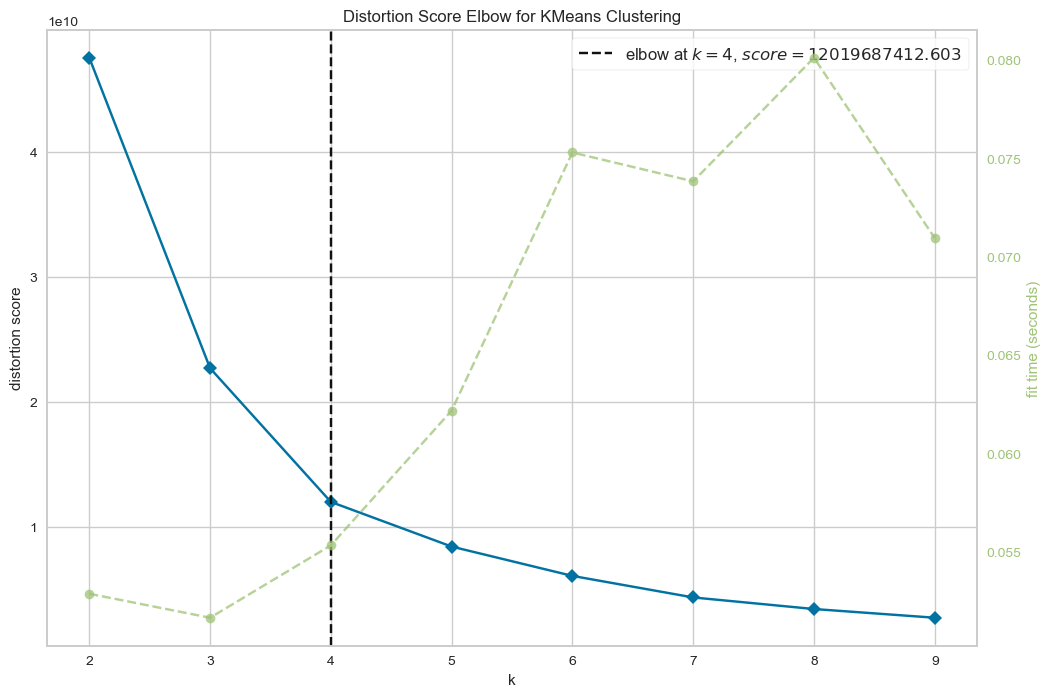

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
#https://en.wikipedia.org/wiki/Elbow_method_(clustering)
fig = plt.figure(figsize=(12,8))

x = df_new[["bmi", "charges"]]

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(x)
visualizer.poof()  

In [39]:
kmeans = KMeans(n_clusters=4)  
kmeans.fit(x)
print(kmeans.cluster_centers_)

[[3.00059116e+01 4.23220266e+03]
 [2.82214857e+01 2.25450305e+04]
 [3.08276968e+01 1.13454244e+04]
 [3.49311364e+01 4.12033027e+04]]


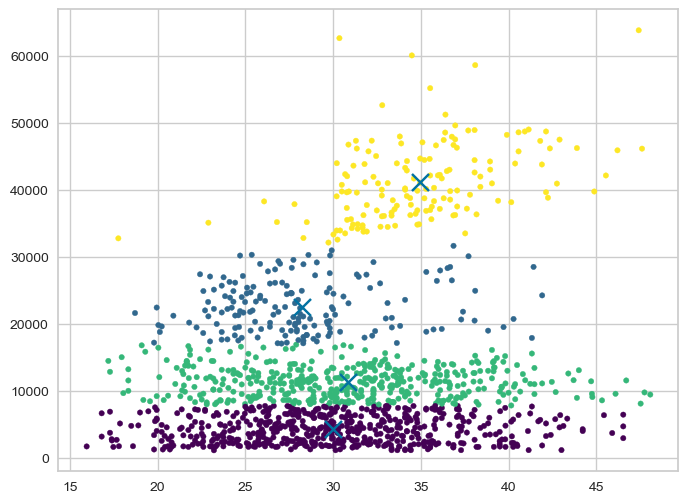

In [40]:
#Визуализируя кластеризацию
fig = plt.figure(figsize=(8,6))
plt.scatter(data = x, y = 'charges', x ='bmi', c=kmeans.labels_, cmap='viridis', s=15)
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], marker='x', s=150)
plt.show()